## MC Pricing of a Forward Future with CVA under CIR Model

Given two rate of interest $r_d$ and $r_f$ where $r_d$ and $r_f$ are the domestic and foreign rate of interest. We can price a forward exchange rate contract according to

$$
F^X(0,T) = X_0\frac{B^f(0,T)}{B^d(0,T)}
$$

where $X_0$ is the initial domestic/foreign rate of exchange and, $B^f(0,T)$ and $B^d(0,T)$ are the domestic and foreign zero-coupon bond price at time $T$.

Let us define CVA of the following form

$$
\text{CVA}_t = \mathbb{E}_t\left[\left(1-R_{cp}\right)\int_t^T D_t(s)FV^{+}(s)SP_{us}(s)PD_{cp}(s)ds\right]
$$

where the variables are as described in the project prospectus. 

Define the stopping time $\tau_x := \min \left\{t: x \text{ defaults} \right\}$. Then we can define the probability of defaults for both parties as 

$$
\mathbb{P}[\tau_{us}\leq 1] = 0.01
$$
$$
\mathbb{P}[\tau_{cp}\leq 1] = 0.05
$$

We can model this as a Poisson distribution with default intensity per year as $\lambda_{us}$ and $\lambda_{cp}$. For a given poisson distribution the probability of default in one year is equivalent to $$\mathbb{P}(X=1) = \frac{(\lambda T)^1\cdot e^{-\lambda T}}{1} = \lambda e^{-\lambda}.$$

Together with the probability of default for both parties we get that 
$$
\lambda_{us} = 0.0101\\
\lambda_{cp} = 0.0527
$$


## CIR Model

We are going to use the following CIR stochastic differential equation 

$$
dr_t = a\left(b-r_t\right)dt + \sigma\sqrt{r_t}dW_t.
$$
To model the interest rate.

Under no arbitrage assumption, a bond may be priced via

$$
P(t,T) = A(t,T)\exp\left(-B(t,T)r_t\right)
$$

where

$$
A(t,T) = \left(\frac{2h\exp\left((a+h)(T-t)/2\right)}{2h+(a+h)(\exp((T-t)h)-1}\right)^{2ab/\sigma^2},
$$

$$
B(t,T) = \frac{2\left(\exp((T-t)h)-1\right)}{2h+(a+h)(\exp((T-t)h)-1},
$$

$$
h = \sqrt{a^2+2\sigma^2}.
$$

We also have the following information in regards to the moments of the bond under CIR model which are

$$
\mathbb{E}[r_t|r_0] = r_0e^{-at}+b(1-e^{-at}),
$$

$$
\text{Var}[r_t|r_0] = r_0\frac{\sigma^2}{a}\left(e^{-at}-e^{-2at}\right) + \frac{b\sigma^2}{2a}\left(1-e^{-at}\right)^2.
$$

## Theoretical Pricing Functions

In [1]:
def cir_bond_price(dynamics, contract):
    """
    Price of a bond under CIR model
    """
    a, b, sigma, r_t, t, T = dynamics.a, dynamics.b, dynamics.sigma, dynamics.r0, 0, contract.T
    
    h = np.sqrt(a**2+2*sigma**2)
    B = (2*(np.exp((T-t)*h)-1))/(2*h+(a+h)*(np.exp((T-t)*h)-1))
    A = (2*h*np.exp((a+h)*(T-t)/2)/(2*h+(a+h)*
        (np.exp((T-t)*h)-1)))**(2*a*b/sigma**2)
    return A*np.exp(-r_t*B)
    
def fx_forward_price(dynamics, contract):
    """
    Function that computes the analytical price of a forward exchange rate given the parameters of 2 short rate following CIR SDE 
    """
    # Need to check how to compute the theoretical price given that both bonds are correlated 
    X0, dynamics_f, dynamics_d = dynamics.X0, dynamics.foreign_bond, dynamics.domestic_bond
    
    bond_f = cir_bond_price(dynamics_f, contract)
    bond_d = cir_bond_price(dynamics_d, contract)
    #print(bond_f, bond_d)
    return X0*bond_f/bond_d

def call_fx_forward_price(dynamics, contract):
    
    rf, T, K = dynamics.risk_free_rate, contract.T, dynamics.K
    forward_price = fx_forward_price(dynamics, contract)
   # print(forward_price)
    return np.exp(-rf*T)*np.maximum(forward_price-K,0)
    

In [2]:
import numpy as np
from scipy import interpolate
from scipy.sparse import diags
from scipy.sparse.linalg import spsolve
from tqdm import tqdm
import matplotlib.pyplot as plt 
import pandas as pd
import time
from mpl_toolkits.mplot3d import Axes3D
plt.style.use('fivethirtyeight')

##  Dynamics and Contracts

In [3]:
# Initialize values for the Dynamics for debugging purposes
class InvalidParameters(Exception):
    pass

class CIR_Bond():
    def __init__(self, name, r0, a, b, sigma):
        self.name = name # name of the bond
        self.r0 = r0 # initial interest rate
        self.a = a # parameter in CIR model
        self.b = b # parameter in CIR model
        self.sigma = sigma # parameter in CIR model
        
        # to prevent negative interest rate
        if 2*self.a*self.b < self.sigma**2:
            raise InvalidParameters("Invalid Parameters, do not meet requirement 2ab >= sigma^2")
            
    def __repr__(self):
        return "{} CIR Bond with r0={:.4f}, a={:.4f}, b={:.4f}, sigma={:.4f}".format(self.name, self.r0, self.a, self.b, self.sigma)
            


class FX_Forward_Future():
    def __init__(self,X0,K,domestic_bond, foreign_bond, risk_free_rate, corr=0):
        self.X0 = X0 # Initial currency exchange rate
        self.K = K # Strike price of forward contract 
        self.domestic_bond = domestic_bond #domestic bond
        self.foreign_bond = foreign_bond #foreign bond
        self.risk_free_rate = risk_free_rate
        self.corr = corr #correlation between the two assets
        
    def __repr__(self):
        str1 = repr(domestic_bond)
        str2 = repr(foreign_bond)
        
        text = str1 +'\n' + str2 +'\n' + "Initial Currency Exchange Rate = {:.4f}".format(self.X0) + \
        '\n'+"Strike of the contract = {:.4f}".format(self.K) + \
        '\n'+'Correlation among the currencies is {:.4f}'.format(self.corr)
        
        return text
        

class Player():
    def __init__(self, name, def_intensity, recovery_rate):
        self.name = name
        
        if def_intensity < 0:
            raise ValueError("Intensity of default must be positive.")
        else:
            self.def_intensity = def_intensity # default intensity of the poisson process (lambda)
            
        if recovery_rate < 0 or recovery_rate > 1:
            raise ValueError("Recovery Rate must be between 0 and 1.")
        else:
            self.recovery_rate = recovery_rate # recovery rate in case of default (R) in the CVA formula 
            
    def __repr__(self):
        return "{} with a poisson intensity of default {:.4f} for a year with a recovery rate of {:.4f}".format(self.name, self.def_intensity, self.recovery_rate)
            
class Contract:
    pass

class MC:
    pass

domestic_bond = CIR_Bond('Domestic', 0.12, 3, 0.08, 0.08)
foreign_bond = CIR_Bond('Foreign', 0.03, 4, 0.10, 0.12)

forward_future = FX_Forward_Future(1.2,1.2,domestic_bond, foreign_bond, 0.015, 0.35)   

pricing_party = Player("Pricing Party", 0.0101, 0.5)
counter_party = Player("Counter Party", 0.0527, 0.3)

contract = Contract()
contract.T = 1 

MonteCarlo=MC()
MonteCarlo.N = 1000   # Number of timesteps on each path
MonteCarlo.M = 1000  # Number of paths.  Change this if necessary.
MonteCarlo.seed = 0

print(forward_future,pricing_party,counter_party, sep='\n'*2)

Domestic CIR Bond with r0=0.1200, a=3.0000, b=0.0800, sigma=0.0800
Foreign CIR Bond with r0=0.0300, a=4.0000, b=0.1000, sigma=0.1200
Initial Currency Exchange Rate = 1.2000
Strike of the contract = 1.2000
Correlation among the currencies is 0.3500

Pricing Party with a poisson intensity of default 0.0101 for a year with a recovery rate of 0.5000

Counter Party with a poisson intensity of default 0.0527 for a year with a recovery rate of 0.3000


## Monte Carlo Forward Future Pricing

In [4]:
def cva_eval_cir_call_fx_forward_pricer(forward_future,contract, MC, main_player, counter_party):
    """
    Pricer via Monte-Carlo for the evaluation of a Call on FX Forward contract with CVA where the interest-rate is modeled using CIR
    """
    
    # Importing the parameters of the objects we are passing to the pricer
    r0_us, a_us, b_us, sigma_us = forward_future.domestic_bond.r0, forward_future.domestic_bond.a, forward_future.domestic_bond.b, forward_future.domestic_bond.sigma
    r0_cp, a_cp, b_cp, sigma_cp = forward_future.foreign_bond.r0, forward_future.foreign_bond.a, forward_future.foreign_bond.b, forward_future.foreign_bond.sigma
    X0, K, rf = forward_future.X0, forward_future.K, forward_future.risk_free_rate
    corr = forward_future.corr
    
    T = contract.T
    
    N, M, seed = MC.N, MC.M, MC.seed
    
    us_def_intensity, us_recovery_rate = main_player.def_intensity, main_player.recovery_rate
    cp_def_intensity, cp_recovery_rate = counter_party.def_intensity, counter_party.recovery_rate
    
    np.random.seed(seed)
    
    dt = T/float(N) #timestep size
    cov_matrix = np.array([[1.,corr],[corr,1.]]) # covariance matrix to generate the dependent brownian motion 
    
    # Compute the paths of the evolution of the interest and bond price across the timeline for CIR model
    def mean_cir(r0,a,b,t):
        return np.exp(-a*t)*(r0+b*(np.exp(a*t)-1))
    
    def var_cir(r0,a,b,t,sigma):
        part1 = np.exp(-a*t)*r0*(sigma**2/a)*(1-np.exp(-a*t))
        part2 = ((b*sigma**2)/(2*a))*(1-np.exp(-a*t))**2
        return part1 + part2
    
    # Simulation of the short-rates 
    Z_matrix = np.random.multivariate_normal(np.zeros(2),cov_matrix,size=(M,N+1))
    rates_cp = np.add(np.array([mean_cir(r0_cp,a_cp,b_cp,dt*t_) for t_ in range(N+1)]),np.sqrt([var_cir(r0_cp,a_cp,b_cp,dt*t_,sigma_cp) for t_ in range(N+1)])*Z_matrix[:,:,0]) #Simulation rates base on CIR SDE
    rates_us = np.add(np.array([mean_cir(r0_us,a_us,b_us,dt*t_) for t_ in range(N+1)]),np.sqrt([var_cir(r0_us,a_us,b_us,dt*t_,sigma_us) for t_ in range(N+1)])*Z_matrix[:,:,1]) #Simulation rates base on CIR SDE
    time_steps = [x*dt for x in range(N+1)]
    
    num_paths=len(rates_cp)
    
    # Poisson simulation for defaults 
    us_defaults = np.random.poisson(us_def_intensity*dt,size=(num_paths,N+1)) # poisson generated defaults
    cp_defaults = np.random.poisson(cp_def_intensity*dt,size=(num_paths,N+1)) # poisson generated defaults
    
    us_filter = us_defaults.sum(axis=1) != 0  # This gives a filter for simulations where there is a default on the part of the seller
    cp_filter = cp_defaults.sum(axis=1) != 0 # This gives a filter for simulations where there is a default on the part of the buyer
    
    first_us_default = np.where(us_filter, us_defaults.argmax(axis=1), float('inf')) # This output an array with the index of the first default for each simulation 
    first_cp_default = np.where(cp_filter, cp_defaults.argmax(axis=1), float('inf'))  # This output an array with the index of the first default for each simulation 
    cp_defaults  = np.where(first_cp_default < first_us_default, 1, np.nan) * first_cp_default # For each sim, if cp default first array element is index of default, otherwise np.nan
    us_defaults = np.where(first_us_default < first_cp_default, 1, np.nan) * first_us_default # For each sim, if us default first array element is index of default, otherwise np.nan
    
    us_DVA = np.zeros(num_paths)
    cp_CVA = np.zeros(num_paths)
    
    bond_prices_cp = np.exp(-(np.array(rates_cp*dt).cumsum(axis=1))) 
    bond_prices_us = np.exp(-(np.array(rates_us*dt).cumsum(axis=1)))
    
    forward_future_prices = X0*bond_prices_cp/bond_prices_us
    
    fx_forward_value = np.zeros(num_paths)
    
    for i in range(num_paths):
        if np.isnan(cp_defaults[i]):
            pass
        else:
            index_default = int(cp_defaults[i]) # find's the time of the default
            stopping_time = index_default*dt #Time of default
            cp_CVA[i] = (1-cp_recovery_rate)*(np.exp(-rf*stopping_time)*np.maximum(forward_future_prices[i][index_default]-K,0)) # computes the defaulted value from the recovery rate and discounted risk-free rate
            fx_forward_value[i] = np.exp(-rf*stopping_time)*np.maximum(forward_future_prices[i][index_default]-K,0) # Value of the forward contract at time 0 
        """
        Possible extension to DVA
        if np.isnan(us_defaults[i]):
            pass
        else:
            index_default = int(us_defaults[i]) # find's the time of the default 
            stopping_time = index_default*dt #Time of default
            us_DVA[i] = -(1-us_recovery_rate)*(np.exp(-rf*stopping_time)*np.maximum(forward_future_prices[i][index_default]-K,0)) # computes the defaulted value from the recovery rate and discounted risk-free rate
            fx_forward_value[i] = np.exp(-rf*stopping_time)*np.maximum(forward_future_prices[i][index_default]-K,0) # Value of the forward contract at time 0 
        """
            
        if fx_forward_value[i] == 0:
            fx_forward_value[i] = np.exp(-rf*T)*np.maximum(forward_future_prices[i,-1]-K,0) #if no default the value of the call on forward is the discounted price of call at terminal value
    
    xVA = us_DVA + cp_CVA # xVA being the value lost when counter party defaults - value lost when seller default 
    
    return np.mean(fx_forward_value), np.std(fx_forward_value)/np.sqrt(len(fx_forward_value)), np.mean(xVA), np.std(xVA)/np.sqrt(len(xVA))# return mean of the MC and std 

In [5]:
Price, error, CVA, CVA_error = cva_eval_cir_call_fx_forward_pricer(forward_future,contract, MonteCarlo, pricing_party, counter_party)

print("""\tValue of the Forward FX contract is: {:.4f} \n
        MC estimate error is: {:.8f} \n 
        CVA of the contract is: {:.4f} \n 
        MC estimate error of CVA is {:.6f}""".format(Price,error,CVA,CVA_error))

	Value of the Forward FX contract is: 0.0120 

        MC estimate error is: 0.00004028 
 
        CVA of the contract is: 0.0006 
 
        MC estimate error of CVA is 0.000081


## Analysis of the Monte-Carlo Pricing Method

In [6]:
num_prices=100
fxspot_mc = np.linspace(forward_future.X0 ,forward_future.X0 + 0.2, num_prices)

N_arr = [100, 500, 1000, 5000, 10000]
M_arr = [100, 500, 1000, 5000, 10000]

graph_callmc = []
graph_cva = []
graph_theo = []
graph_difference = []
df = pd.DataFrame(columns = M_arr, index = N_arr)
init_time = time.time()
for N in N_arr:
    for M in M_arr:
        print("Currently working on N={} and M={} current total time of {:.2f}s".format(N,M, time.time() - init_time))
        callprice_mc=[]
        cva_callprice_mc=[]
        uncorrelated_theo_price = []
        difference = []
        
        MonteCarlo.N = N
        MonteCarlo.M = M
        
        start = time.time()
        for X_ in fxspot_mc:
            forward_future.X0 = X_
            call, std, cva, cva_std = cva_eval_cir_call_fx_forward_pricer(forward_future,contract, MonteCarlo, pricing_party, counter_party)
            
            callprice_mc.append(call)
            cva_callprice_mc.append(cva)
            uncorrelated_theo_price.append(call_fx_forward_price(forward_future, contract))
            
            difference.append(100*abs(call_fx_forward_price(forward_future, contract) - call)/call_fx_forward_price(forward_future, contract))
            forward_future.X0 = 1.2
            
            if N == 1000 and M == 1000:
                graph_callmc = callprice_mc.copy()
                graph_cva = cva_callprice_mc.copy()
                graph_theo = uncorrelated_theo_price.copy()
                graph_difference = difference.copy()
                
        end = time.time()
        exec_time = end - start
        avg_rel_error = np.array(difference).mean()
        str_text = "{:.2f}s/{:.4f}%".format(exec_time, avg_rel_error)
        df.loc[N,M] = str_text

Currently working on N=100 and M=100 current total time of 0.00s
Currently working on N=100 and M=500 current total time of 0.53s
Currently working on N=100 and M=1000 current total time of 2.18s
Currently working on N=100 and M=5000 current total time of 5.28s
Currently working on N=100 and M=10000 current total time of 23.36s
Currently working on N=500 and M=100 current total time of 56.18s
Currently working on N=500 and M=500 current total time of 59.20s
Currently working on N=500 and M=1000 current total time of 67.31s
Currently working on N=500 and M=5000 current total time of 83.58s
Currently working on N=500 and M=10000 current total time of 145.84s
Currently working on N=1000 and M=100 current total time of 253.92s
Currently working on N=1000 and M=500 current total time of 256.79s
Currently working on N=1000 and M=1000 current total time of 268.08s
Currently working on N=1000 and M=5000 current total time of 288.96s
Currently working on N=1000 and M=10000 current total time of

In [7]:
df.columns.set_names('Number of Paths', inplace = True)
df.index.set_names('Number of Time steps', inplace = True)
df

Number of Paths,100,500,1000,5000,10000
Number of Time steps,,,,,
100,0.52s/0.9981%,1.65s/1.1626%,3.10s/1.0976%,18.08s/1.0530%,32.82s/0.9913%
500,3.02s/1.1399%,8.12s/0.5295%,16.27s/0.5325%,62.26s/0.4204%,108.07s/0.4029%
1000,2.87s/0.2494%,11.29s/0.3648%,20.89s/0.4775%,108.19s/0.3374%,182.70s/0.3435%
5000,14.17s/0.3374%,51.66s/0.3916%,100.83s/0.2028%,466.07s/0.2348%,932.37s/0.2818%
10000,31.73s/0.3761%,105.74s/0.2560%,187.05s/0.1591%,954.22s/0.2972%,1932.98s/0.2768%


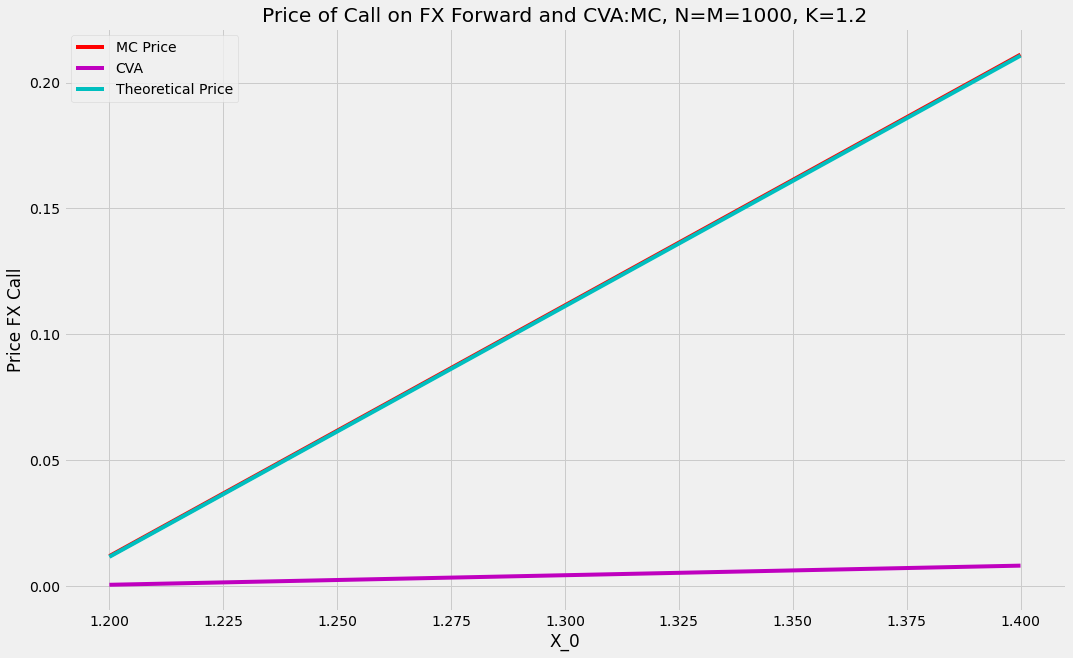

In [8]:
fig = plt.figure(figsize = (16,10))
ax = fig.add_subplot(111)
X = fxspot_mc
for c, Z, l in [('r', graph_callmc, "MC Price"), ('m', graph_cva,"CVA" ), ('c', graph_theo, 'Theoretical Price')]:
    ax.plot(X, Z, c = c, label = l)
    
ax.set_xlabel('X_0')
ax.set_ylabel('Price FX Call')
ax.title.set_text('Price of Call on FX Forward and CVA:MC, N=M=1000, K=1.2')
ax.legend()

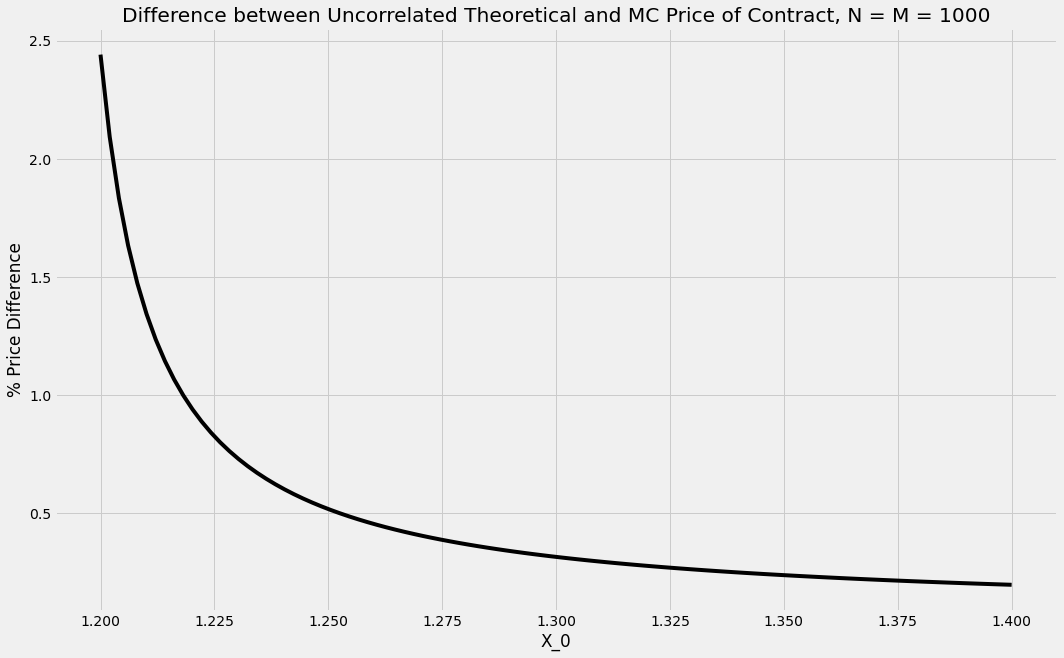

In [9]:
fig = plt.figure(figsize = (16,10))
ax = fig.add_subplot(111)
X = fxspot_mc
ax.plot(X, graph_difference, c='k')
ax.set_xlabel('X_0')
ax.set_ylabel('% Price Difference')
ax.title.set_text('Difference between Uncorrelated Theoretical and MC Price of Contract, N = M = 1000')